In [1]:
%load_ext autoreload
%autoreload 2

# Modelling channelrhodopsin behaviour using equations found in [PyRhO](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full) 
## Toolbox used [here](https://www.biorxiv.org/content/10.1101/417899v1.abstract) and [here](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006027)
## Based on [these examples](http://try.projectpyrho.org/user/m7XO3uuyELQG/notebooks/Prometheus.ipynb)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neurom as nm
from neurom import viewer
from tqdm import tqdm

import brian2 as b2
import pyrho as pr # <-------

# Using pre-made protocols


Running 'step' protocol with Brian for the Four-state ChR2 model... 

{nRuns=1, nPhis=1, nVs=1}


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    <string>:27: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]


Data saved to disk: data\step4s.pkl

Finished 'step' protocol with Brian for the Four-state ChR2 model in 1.93s
--------------------------------------------------------------------------------



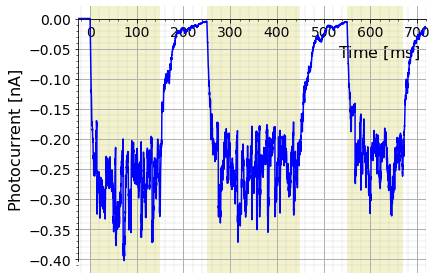

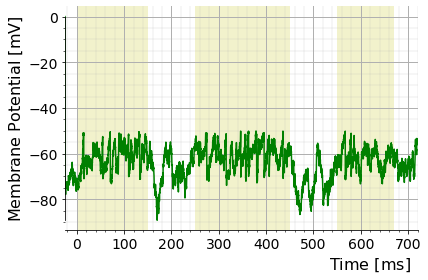

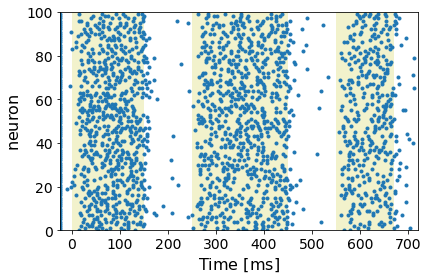

In [3]:
# Defining the ChR2 model
n_states = '4' #number of states in the channel model : 3, 4 or 6
params = pr.modelFits[n_states]['ChR2'] #only ChR2 seems to be pre-packed with pyrho

# Defining the pyrho model
rho = pr.models[n_states](params)

# Defining the equations
netParams = {'tau_m':10*b2.ms,
             'R_m':70*b2.Mohm,
             'E_m':-70*b2.mV,
             'v_t0':-50*b2.mV,
             'sigma':10*b2.mV,
             't_ref':4*b2.ms}
eq_opto = '''
dv/dt = ((-I*R_m)+E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
''' + rho.brian_phi_t # writes the model in a brian-interpretable string
eq_norm = '''
dv/dt = (E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
'''

# Defining the stimulation protocol 
protocol = pr.protocols['step']()
protocol.phis = [1e14] #photons 
protocol.Vs = [None]
protocol.cycles = [[150, 100], [200, 100], [120, 50]] #on-off times
# Defining the neuron
neuron = b2.NeuronGroup(100, eq_opto, threshold='v>v_t0', reset='v=E_m', refractory='t_ref', 
                        namespace=netParams, name='Inputs', method='euler')

# Run the simulation
net = b2.Network(b2.collect())
monitors = {'states' : b2.StateMonitor(neuron, rho.brianStateVars, record=0),   # Record states
            'I'      : b2.StateMonitor(neuron, 'I', record=0),                  # Record current
            'V'      : b2.StateMonitor(neuron, 'v', record=0),                  # Record voltage
            'spikes' : [b2.SpikeMonitor(neuron, name='neuron')]}
net.add(monitors)

sim = pr.simulators['Brian'](protocol, 
                            rho, 
                            pr.simParams['Brian'],
                               net,
                               netParams,
                               monitors)
sim.run()
sim.plot()

# Without the protocol object

In [4]:
print(rho.brian_phi_t)


            dC_1/dt = Gr0*C_2 + Gd1*O_1 - Ga1*C_1 : 1
            dO_1/dt = Ga1*C_1 - (Gd1+Gf)*O_1 + Gb*O_2 : 1
            dO_2/dt = Ga2*C_2 + Gf*O_1 - (Gd2+Gb)*O_2 : 1
            C_2 = 1 - C_1 - O_1 - O_2 : 1
            Ga1 = Theta*k1*phi(t)**p/(phi(t)**p+phi_m**p) : second**-1
            Ga2 = Theta*k2*phi(t)**p/(phi(t)**p+phi_m**p) : second**-1
            Gf = Gf0 + Theta*k_f*phi(t)**q/(phi(t)**q+phi_m**q) : second**-1
            Gb = Gb0 + Theta*k_b*phi(t)**q/(phi(t)**q+phi_m**q) : second**-1
            f_v = (1-exp(-(v-E)/v0))/((v-E)/v1) : 1
            f_phi = O_1+gam*O_2 : 1
            I = g0*f_phi*f_v*(v-E) : amp
            Theta = int(phi(t) > 0*phi(t)) : 1 (shared)
            


In [5]:
for i,k in params.items() :
    print(i,k.value)

g0 114000.0
gam 0.00742
phi_m 2.33e+17
k1 4.15
k2 0.868
p 0.833
Gf0 0.0373
k_f 0.0581
Gb0 0.0161
k_b 0.063
q 1.94
Gd1 0.105
Gd2 0.0138
Gr0 0.00033
E 0
v0 43
v1 17.1


In [6]:
test = ''' dC/dt = Gr*D - Ga*C                         : 1
            dO/dt = Ga*C - Gd*O                         : 1
            dD/dt = Gd*O - Gr*D                         : 1
            Ga = Theta*k_a*((phi**p)/(phi**p + phi_m**p))        : second**-1
            Gr = Gr0 + Theta*k_r*((phi**q)/(phi**q + phi_m**q))  : second**-1
            f_phi = O                                   : 1
            f_v = (1-exp(-(v-E)/v0))/((v-E)/v1)         : 1
            I = g0*f_phi*f_v*(v-E)                      : amp
            Theta = int(phi > 0*phi)              : 1 (shared)'''

In [7]:
b2.start_scope()

# Extracting the opsin model from PyRhO
n_states = '3' #number of states in the channel model : 3, 4 or 6
pyrho_params = pr.modelFits[n_states]['ChR2'] #only ChR2 seems to be pre-packed with pyrho
rho = pr.models[n_states](pyrho_params)
opsin_dict = {}
for i, k in pyrho_params.items() :
    opsin_dict[i] = k.value

phi = 0 * b2.ms
# Defining the equations
netParams = {'tau_m':10*b2.ms,
             'R_m':70*b2.Mohm,
             'E_m':-70*b2.mV,
             'v_t0':-50*b2.mV,
             'sigma':10*b2.mV,
             't_ref':4*b2.ms}
netParams.update(opsin_dict)
eq_opto = '''
dv/dt = ((-I*R_m)+E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
'''
eq_opto += rho.brian_phi_t

# Defining the stimulation protocol 
'''protocol = pr.protocols['step']()
protocol.phis = [1e18] #photons ?
protocol.Vs = [None]
protocol.cycles = [[150, 100], [200, 75]]'''
# Defining the neuron
neuron = b2.NeuronGroup(100, eq_opto, threshold='v>v_t0', reset='v=E_m', refractory='t_ref', 
                        namespace=netParams, name='Inputs', method='euler')

# Run the simulation
net = b2.Network(b2.collect())
mon = b2.SpikeMonitor(neuron, name='neuron')
'''monitors = {'states' : b2.StateMonitor(neuron, rho.brianStateVars, record=0),   # Record states
            'I'      : b2.StateMonitor(neuron, 'I', record=0),                  # Record current
            'V'      : b2.StateMonitor(neuron, 'v', record=0),                  # Record voltage
            'spikes' : [b2.SpikeMonitor(neuron, name='neuron')]}'''
net.add(mon)

'''sim = pr.simulators['Brian'](protocol, 
                            rho, 
                            pr.simParams['Brian'],
                               net,
                               netParams,
                               monitors)'''
b2.run(100 * b2.ms)


BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\core\network.py", line 901, in before_run
    obj.before_run(run_namespace)
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\groups\neurongroup.py", line 888, in before_run
    self.equations.check_units(self, run_namespace=run_namespace)
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\equations\equations.py", line 972, in check_units
    all_variables)
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\equations\unitcheck.py", line 41, in check_dimensions
    expr_dims = parse_expression_dimensions(expression, variables)
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\parsing\expressions.py", line 303, in parse_expression_dimensions
    arg_unit = parse_expression_dimensions(arg, variables)
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\parsing\expressions.py", line 260, in parse_expression_dimensions
    subunits.append(parse_expression_dimensions(node, variables))
  File "C:\Users\Hugo\AppData\Roaming\Python\Python37\site-packages\brian2\parsing\expressions.py", line 283, in parse_expression_dimensions
    'deals with units.') % expr.func.id)
ValueError: Function phi does not specify how it deals with units.

Error encountered with object named "Inputs".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-7-944a783b5b13>", line 32, in <module>
    namespace=netParams, name='Inputs', method='euler')

An error occurred when preparing an object. ValueError: Function phi does not specify how it deals with units.
(See above for original error message and traceback.)

In [ ]:
phi = 0
netParams.update({'phi' : phi * pr.modelUnits['phi_m']})
net.run(duration = 150 * b2.ms, namespace = netParams)

In [ ]:
def run(self, verbose=verbose): 
        """Main routine to run the simulation protocol"""        
        RhO = self.RhO
        Prot = self.Prot
        
        self.prepare(Prot)
        
        if verbose > 0:
            print("\n================================================================================")
            print("Running '{}' protocol with {} for the {} model... ".format(Prot, self, RhO))
            print("================================================================================\n")
            print("{{nRuns={}, nPhis={}, nVs={}}}".format(Prot.nRuns, Prot.nPhis, Prot.nVs))
        
        # Change to self.PD ?
        Prot.PD = ProtocolData(Prot.protocol, Prot.nRuns, Prot.phis, Prot.Vs)
        Prot.PD.peak_ = [[[None for v in range(Prot.nVs)] for p in range(Prot.nPhis)] for r in range(Prot.nRuns)]
        Prot.PD.ss_ = [[[None for v in range(Prot.nVs)] for p in range(Prot.nPhis)] for r in range(Prot.nRuns)]
        if hasattr(Prot, 'runLabels'):
            Prot.PD.runLabels = Prot.runLabels
        
        if verbose > 1: 
            Prot.printParams()
        
        for run in range(Prot.nRuns):                   # Loop over the number of runs...
            
            cycles, delD = Prot.getRunCycles(run)
            pulses, totT = cycles2times(cycles, delD)
            
            for phiInd, phiOn in enumerate(Prot.phis):  # Loop over light intensity...
                
                if verbose > 1 and (Prot.nPhis > 1 or (run == 0 and phiInd == 0)):
                    RhO.dispRates()
                
                for vInd, V in enumerate(Prot.Vs):      # Loop over clamp voltage ### N.B. solution variables are not currently dependent on V
                    
                    ### Reset simulation environment...
                    self.initialise()
                    
                    if Prot.squarePulse and self.simulator is 'Python':
                        I_RhO, t, soln = self.runTrial(RhO, phiOn, V, delD, cycles, self.dt, verbose)

                    else: # Arbitrary functions of time: phi(t)
                        phi_ts = Prot.phi_ts[run][phiInd][:]
                        I_RhO, t, soln = self.runTrialPhi_t(RhO, phi_ts, V, delD, cycles, self.dt, verbose) #, totT
                        
                    PC = PhotoCurrent(I_RhO, t, pulses, phiOn, V, Prot.protocol)
                    #PC.alignToTime()

                    PC.states = soln
                    Prot.PD.trials[run][phiInd][vInd] = PC
                    Prot.PD.peak_[run][phiInd][vInd] = PC.peak_
                    Prot.PD.ss_[run][phiInd][vInd] = PC.ss_
                    
                    self.saveExtras(run, phiInd, vInd)
                    
                    if verbose > 1:
                        print('Run=#{}/{}; phiInd=#{}/{}; vInd=#{}/{}; Irange=[{:.3g},{:.3g}]'.format(run,Prot.nRuns, phiInd,Prot.nPhis, vInd,Prot.nVs, PC.range_[0],PC.range_[1]))
        
        Prot.finish(PC, RhO)
        
        if Prot.saveData:
            Prot.dataTag = str(RhO.nStates)+"s"
            saveData(Prot.PD, Prot.protocol+Prot.dataTag)
        
        self.runTime = wallTime() - t0
        if verbose > 0:
            print("\nFinished '{}' protocol with {} for the {} model in {:.3g}s".format(Prot, self, RhO, self.runTime))
            print("--------------------------------------------------------------------------------\n")
            
        return Prot.PD

In [ ]:
sim.run??

In [ ]:
protocol??

# Counting the volume in a voxel
Given a voxel resolution R, the neuron simply belongs to the cluster coordinates * R, floored to the integer value

In [ ]:
resolution = .01 #points
example_voxel = np.int16(np.array([278, 627 , 184]) * resolution)
example_voxel

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

total_in_voxels = 0
for pts in tqdm(neuron.points, 'Visualizing...') :
    
    if (np.int16(pts[:3] * resolution) == example_voxel).all() : 
        ax.scatter(pts[0], pts[1], pts[2], c = 'r')
        total_in_voxels +=1 
    else : 
        ax.scatter(pts[0], pts[1], pts[2], c = 'k')


print('%d neurons in the voxel' % total_in_voxels)
plt.show()

# Making the neuron model
where oc is the optogenetic current

In [ ]:
b2.start_scope()

g_adjustement = .0005                    #  multiplier of the leak current
C = 1 * b2.nF                               # membrane capacitance analysis:ignore
gL = 1. * b2.uS * g_adjustement             # leak currents analysis:ignore
EL = -70. * b2.mV                           # effective rest potential
v_thresh = -50. * b2.mV                     # effective threshold potential
v_reset = EL                                # post-AP reset potential analysis:ignore
Ee = 0 * b2.mV                              # exc reversal potential analysis:ignore
Ei = -70 * b2.mV                            # inh reversal potential analysis:ignore
DeltaT = 2 * b2.mV                          # AP post cut shape
Vcut = v_thresh + 5 * DeltaT                # actual threshold potential analysis:ignore

oc = total_in_voxels * .005 * b2.uS
eqNeuron = """
dvm/dt   = (gL*(EL - vm) + gL*DeltaT*exp((vm - v_thresh)/DeltaT)+ oc*(Ee-vm) )/ C : volt
"""
 

optoN = b2.NeuronGroup(1, eqNeuron, threshold='vm>Vcut', reset="vm=v_reset",
                      method='euler', name='neuronopto')
spikemon = b2.SpikeMonitor(optoN)

In [ ]:
b2.run(100*b2.ms)

In [ ]:
spikemon.spike_trains()